In [1]:
from openai import OpenAI
from dotenv import load_dotenv
import os 
import gradio as gr 
import anthropic
import google.generativeai

In [2]:
load_dotenv(override=True)
google_api_key = os.getenv('GOOGLE_API_KEY')
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

In [3]:
 #Connect to OpenAI, Anthropic and Google

openai = OpenAI()

claude = anthropic.Anthropic()

google.generativeai.configure()

In [4]:
gemini_via_openai_client = OpenAI(
    api_key=google_api_key, 
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

In [5]:
system_message = "You are an assistant that is great at telling jokes"
user_prompt = "Tell a light-hearted joke for an audience of Data Scientists"

In [6]:
prompts = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": user_prompt}
  ]

In [7]:
def stream_gpt(prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt}
      ]
    stream = openai.chat.completions.create(
        model='gpt-4o-mini',
        messages=messages,
        stream=True
    )
    result = ""
    for chunk in stream:
        result += chunk.choices[0].delta.content or ""
        yield result

In [8]:
def stream_claude(prompt):
    result = claude.messages.stream(
        model="claude-3-haiku-20240307",
        max_tokens=1000,
        temperature=0.7,
        system=system_message,
        messages=[
            {"role": "user", "content": prompt},
        ],
    )
    response = ""
    with result as stream:
        for text in stream.text_stream:
            response += text or ""
            yield response

In [9]:
def stream_gemini(prompt):
    stream = gemini_via_openai_client.chat.completions.create(
        model="gemini-2.0-flash",
        messages=[
            {"role": "user", "content": prompt},
        ],
        stream=True
    )
    result = ""
    for chunk in stream:  # Use 'stream' here, not 'result'
        result += chunk.choices[0].delta.content or ""
        yield result

In [10]:
def stream_model(prompt, model):
    if model=="GPT":
        result = stream_gpt(prompt)
    elif model=="Claude":
        result = stream_claude(prompt)
    elif model=="Gemini":
        result= stream_gemini(prompt)
    else:
        raise ValueError("Unknown model")
    yield from result

In [ ]:
view = gr.Interface(
    fn=stream_model,
    inputs=[gr.Textbox(label="Your message:"), gr.Dropdown(["GPT", "Claude","Gemini"], label="Select model", value="GPT")],
    outputs=[gr.Markdown(label="Response:")],
    flagging_mode="never"
)
view.launch()

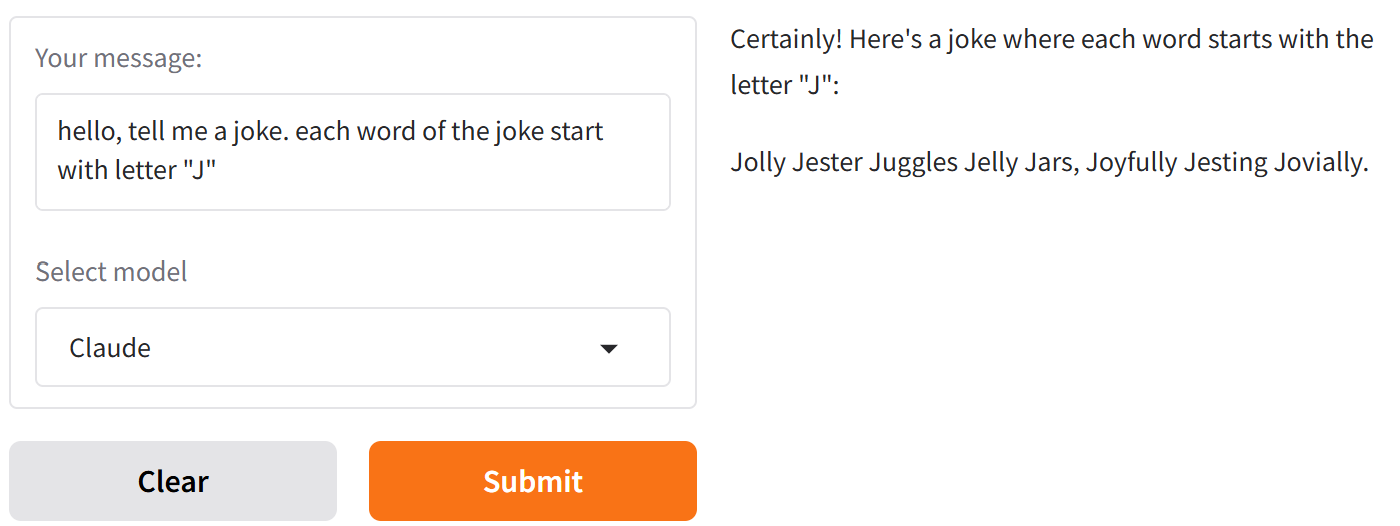

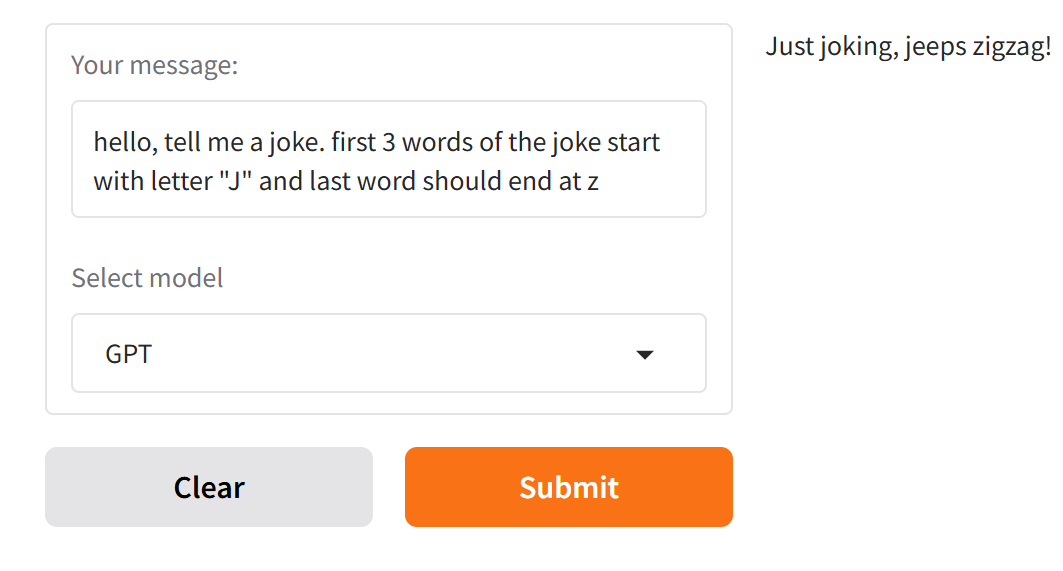

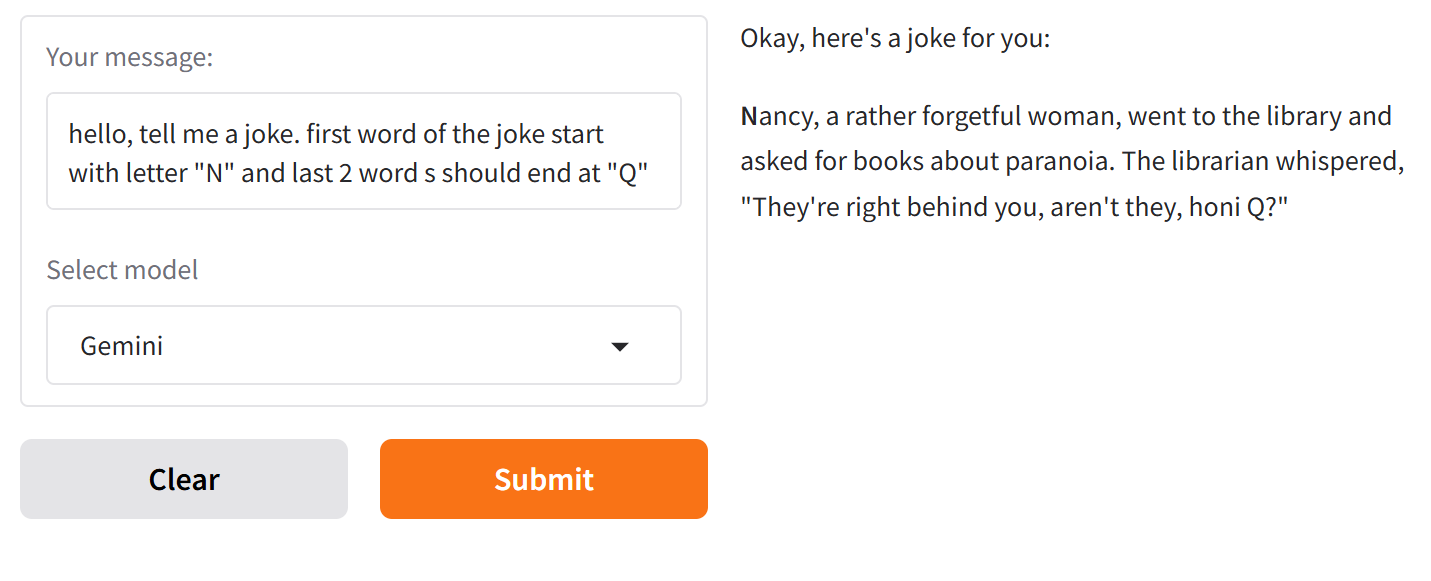

# This is a Multi-AI Streaming Chat Interface built with Gradio that allows users to interact with three different AI models (GPT, Claude, and Gemini) through a single web interface with real-time streaming responses.